# MIDAS soft X-ray example

Here we show a toy example of inferring 1D profiles of electron temperature and density based on measurements of the electron pressure profile, the soft X-ray emission profile and a line-integrated density measurement.

First, import and plot the data for the example:

In [1]:
from data import brem_axis, brem_data, brem_sigma
from data import pe_axis, pe_data, pe_sigma
from data import inter_axis, inter_data, inter_sigma

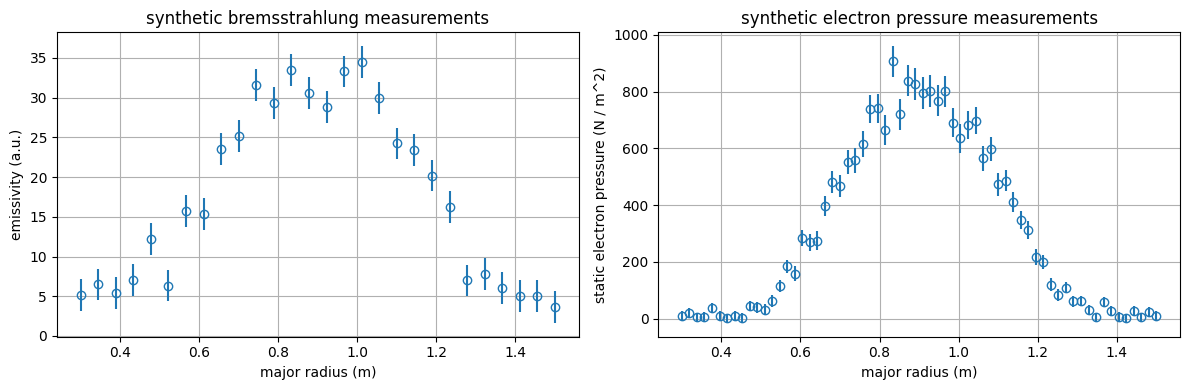

In [2]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.errorbar(brem_axis, brem_data, yerr=brem_sigma, ls="none", marker="o", markerfacecolor="none")
ax1.grid()
ax1.set_xlabel("major radius (m)")
ax1.set_ylabel("emissivity (a.u.)")
ax1.set_title("synthetic bremsstrahlung measurements")

ax2 = fig.add_subplot(1, 2, 2)
ax2.errorbar(pe_axis, pe_data, yerr=pe_sigma, ls="none", marker="o", markerfacecolor="none")
ax2.grid()
ax2.set_xlabel("major radius (m)")
ax2.set_ylabel("static electron pressure (N / m^2)")
ax2.set_title("synthetic electron pressure measurements")
plt.tight_layout()
plt.show()

## Defining diagnostic models
In `midas`, models are classes which inherit from an abstract base-class `DiagnosticModel`. This class can fully implement a forward-model of a diagnostic, or act as a light wrapper around a model implemented elsewhere, allowing that model to interact with `midas`. `DiagnosticModel` has two abstract methods, `predictions` and `predictions_and_jacobians`. Any information which the model requires in order to evaluate its predictions is specified using the `FieldRequest` and `ParameterVector` classes.

Here we implement a toy model for bremsstrahlung emission $\mathcal{E}$:
$$
\mathcal{E} = n_e^2\sqrt{T_e} + b
$$
for electron temperature $T_e$, electron density $n_e$ and a background level parameter $b$.

To evaluate the model, we need the values of $T_e$ and $n_e$ at the radial positions of our data. In `midas`, diagnostic models are independent of models for plasma fields like $T_e$, $n_e$, and we request values for these fields using the `FieldRequest` class. Instances of `FieldRequest` are stored as a list assigned to the `field_requests` instance variable of the model class.

Other parameters required by the model, such as the background value in this case, can be specified using the `ParameterVector` class. Instances of `ParameterVector` are stored as a list assigned to the `parameters` instance variable of the model class.

In [3]:
from numpy import ndarray, zeros, fill_diagonal, sqrt, linspace, exp
from midas.models import DiagnosticModel
from midas.parameters import FieldRequest, ParameterVector


class BremsstrahlModel(DiagnosticModel):
    def __init__(self, radius: ndarray):
        # The given 'radius' array specifies the location of the emission measurements,
        # so we use 'FieldRequest' to request the temperature and density at those positions
        self.field_requests = [
            FieldRequest(name="te", coordinates={"radius": radius}),
            FieldRequest(name="ne", coordinates={"radius": radius}),
        ]
        # The model also requires a background value, so we use 'ParameterVector'
        # to specify a background free parameter:
        self.parameters = [ParameterVector(name="background", size=1)]

    def predictions(self, te: ndarray, ne: ndarray, background: float):
        return sqrt(te) * ne**2 + background

    def predictions_and_jacobians(self, te: ndarray, ne: ndarray, background: float):
        predictions = sqrt(te) * ne**2 + background
        # create arrays for the jacobians of the predictions with respect to each input:
        te_jac = zeros([te.size, te.size])
        ne_jac = zeros([te.size, te.size])
        bg_jac = zeros((te.size, 1)) + 1.0
        # calculate the jacobians
        fill_diagonal(te_jac, 0.5*ne**2 / sqrt(te))
        fill_diagonal(ne_jac, 2 * sqrt(te) * ne)
        # The jacobians are returned as a dictionary mapping the input names
        # to the jacobian arrays
        jacobians = {
            "te": te_jac,
            "ne": ne_jac,
            "background": bg_jac
        }
        return predictions, jacobians

Now we import similarly defined models for the electron pressure and density measurements, and create instances of the models:

In [4]:
from models import PressureModel, InterferometerModel

brem_model = BremsstrahlModel(radius=brem_axis)
pe_model = PressureModel(radius=pe_axis)
inter_model = InterferometerModel(radius=inter_axis)

## Building diagnostic likelihoods
...

In [5]:
from midas.likelihoods import DiagnosticLikelihood, GaussianLikelihood

brem_likelihood = DiagnosticLikelihood(
    diagnostic_model=brem_model,
    likelihood=GaussianLikelihood(
        y_data=brem_data,
        sigma=brem_sigma
    ),
    name="bremsstrahlung"
)

inter_likelihood = DiagnosticLikelihood(
    diagnostic_model=inter_model,
    likelihood=GaussianLikelihood(
        y_data=inter_data,
        sigma=inter_sigma
    ),
    name="interferometer"
)

pe_likelihood = DiagnosticLikelihood(
    diagnostic_model=pe_model,
    likelihood=GaussianLikelihood(
        y_data=pe_data,
        sigma=pe_sigma
    ),
    name="pressure"
)

## Adding prior constraints
...

In [6]:
from midas.priors import GaussianProcessPrior
from inference.gp.covariance import SquaredExponential
from inference.gp.mean import ConstantMean

gp_axis = linspace(0.3, 1.5, 16)
te_gp = GaussianProcessPrior(
    covariance=SquaredExponential(),
    mean=ConstantMean(),
    field_positions=FieldRequest(name="te", coordinates={"radius": gp_axis}),
    name="temperature_gp"
)

ne_gp = GaussianProcessPrior(
    covariance=SquaredExponential(),
    mean=ConstantMean(),
    field_positions=FieldRequest(name="ne", coordinates={"radius": gp_axis}),
    name="density_gp"
)

## Defining models for plasma fields
...

In [7]:
from midas.state import PlasmaState
from midas.fields import PiecewiseLinearField
field_axis = linspace(0.3, 1.5, 16)
field_models = [
    PiecewiseLinearField(field_name="te", axis=field_axis, axis_name="radius"),
    PiecewiseLinearField(field_name="ne", axis=field_axis, axis_name="radius"),
]

PlasmaState.specify_field_models(field_models)

## Constructing the posterior
...

In [8]:
components = [
    brem_likelihood,
    pe_likelihood,
    inter_likelihood,
    te_gp,
    ne_gp
]

PlasmaState.build_parametrisation(components)

...

In [9]:
from midas.posterior import Posterior

## MAP estimation
...

In [10]:
te_guess = 500 * exp(-0.5 * ((field_axis - 0.9) / 0.3)**2)
ne_guess = 0.7 * exp(-0.5 * ((field_axis - 0.9) / 0.3)**2)

initial_guess = PlasmaState.merge_parameters(
    {
        "te": te_guess,
        "ne": ne_guess,
        "background": 3.0,
        "te_cov_hyperpars": [4., -3],
        "ne_cov_hyperpars": [-0.2, -3],
        "te_mean_hyperpars": 0.01,
        "ne_mean_hyperpars": 0.01,
    }
)

In [11]:
print(Posterior.log_probability(initial_guess))

-2018.2434007518134


In [12]:
lower_bounds = PlasmaState.merge_parameters(
    {
        "te": 1e-6,
        "ne": 1e-6,
        "background": 1e-6,
        "te_cov_hyperpars": [-2, -5],
        "ne_cov_hyperpars": [-2, -5],
        "te_mean_hyperpars": 0.,
        "ne_mean_hyperpars": 0.,
    }
)

upper_bounds = PlasmaState.merge_parameters(
    {
        "te": 1200.,
        "ne": 10.,
        "background": 20.0,
        "te_cov_hyperpars": [6., -2.5],
        "ne_cov_hyperpars": [3., -2.5],
        "te_mean_hyperpars": 1.,
        "ne_mean_hyperpars": 0.05,
    }
)

In [13]:
from scipy.optimize import minimize
result = minimize(
    fun=Posterior.cost,
    x0=initial_guess,
    jac=Posterior.cost_gradient,
    bounds=[(l, u) for l, u in zip(lower_bounds, upper_bounds)]
)

map_estimate_params = result.x

print("initial guess log-prob", Posterior.log_probability(initial_guess))
print("bfgs solution log-prob", Posterior.log_probability(map_estimate_params))

initial guess log-prob -2018.2434007518134
bfgs solution log-prob -442.7280382476826


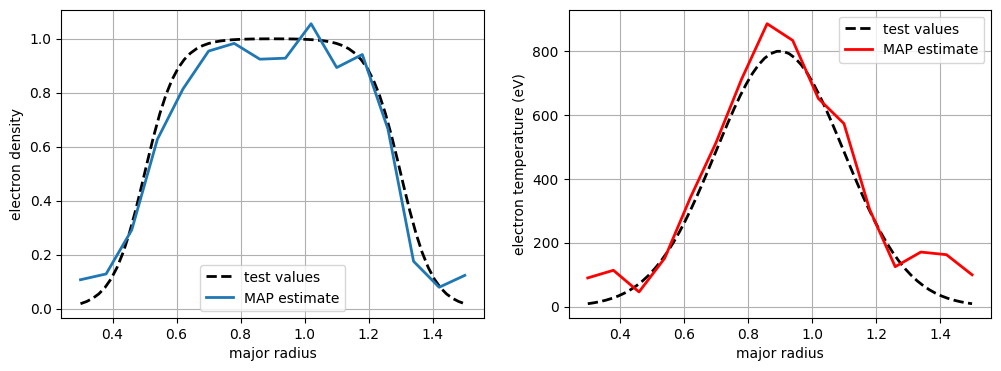

In [37]:
params_dict = PlasmaState.split_parameters(map_estimate_params)

from data import test_axis, test_te, test_ne

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(test_axis, test_ne, label="test values", c="black", lw=2, ls="dashed")
ax1.plot(field_axis, params_dict["ne"], label="MAP estimate", c="C0", lw=2)
ax1.set_ylabel("electron density")
ax1.set_xlabel("major radius")
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(test_axis, test_te, label="test values", c="black", lw=2, ls="dashed")
ax2.plot(field_axis, params_dict["te"], label="MAP estimate", c="red", lw=2)
ax2.set_ylabel("electron temperature (eV)")
ax2.set_xlabel("major radius")
ax2.grid()
ax2.legend()

plt.show()

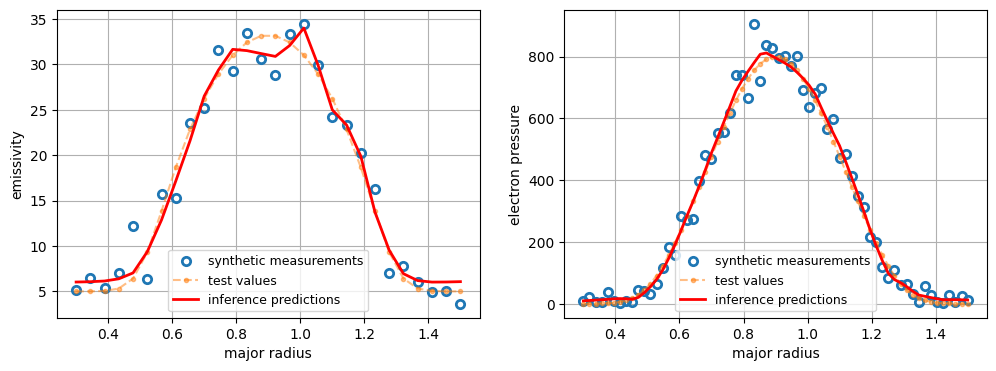

In [15]:
from data import test_axis, test_te, brem_data_clean, pe_data_clean

model_predictions = Posterior.get_model_predictions(map_estimate_params)

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(brem_axis, brem_data, "o", label="synthetic measurements", markerfacecolor="none", markeredgewidth=2)
ax1.plot(brem_axis, brem_data_clean, ".--", alpha=0.5, label="test values")
ax1.plot(brem_axis, model_predictions["bremsstrahlung"], c="red", lw=2, label="inference predictions")
ax1.grid()
ax1.set_ylabel("emissivity")
ax1.set_xlabel("major radius")
ax1.legend(fontsize=9)

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(pe_axis, pe_data, "o", label="synthetic measurements", markerfacecolor="none", markeredgewidth=2)
ax2.plot(pe_axis, pe_data_clean, ".--", alpha=0.5, label="test values")
ax2.plot(pe_axis, model_predictions["pressure"], c="red", lw=2, label="inference predictions")
ax2.grid()
ax2.set_ylabel("electron pressure")
ax2.set_xlabel("major radius")
ax2.legend(fontsize=9)

plt.show()

## Uncertainty quantification using MCMC
...

In [34]:
from inference.approx import get_conditionals

x_cond, p_cond = get_conditionals(
    posterior=Posterior.log_probability,
    bounds=[(l, u) for l, u in zip(lower_bounds, upper_bounds)],
    conditioning_point=map_estimate_params
)

from numpy import ptp
conditional_widths = zeros(PlasmaState.n_params)
for i in range(PlasmaState.n_params):
    extent = x_cond[p_cond[:, i] > p_cond[:, i].max() * 0.1, i]
    conditional_widths[i] = ptp(extent)

...

In [21]:
from inference.mcmc import Bounds, HamiltonianChain

hmc_bounds = Bounds(lower=lower_bounds, upper=upper_bounds)

chain = HamiltonianChain(
    posterior=Posterior.log_probability,
    start=map_estimate_params,
    bounds=hmc_bounds,
    grad=Posterior.gradient,
    epsilon=0.05,
    inverse_mass=conditional_widths ** 2,
    display_progress=False
)
chain.steps = 25

...

In [22]:
chain.advance(2500)

...

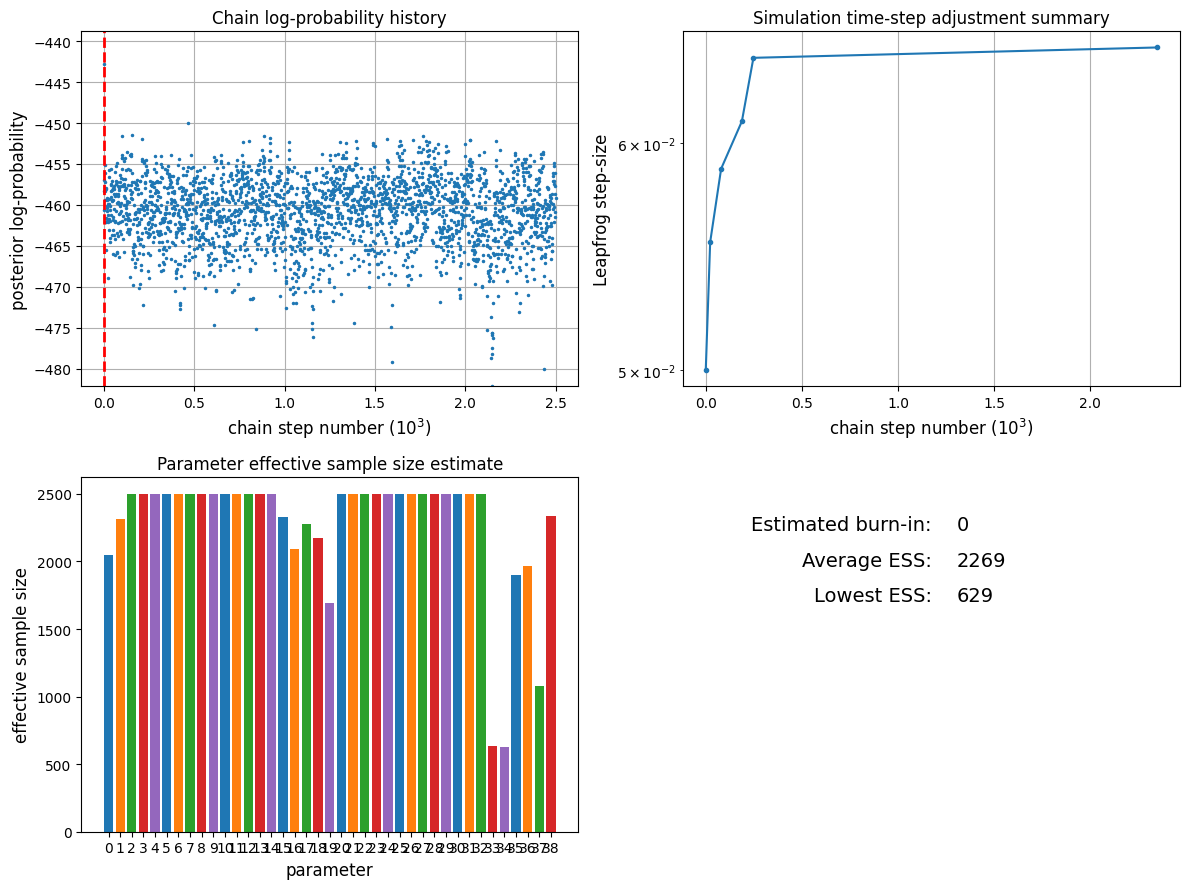

In [23]:
chain.plot_diagnostics()

In [33]:
samples = chain.get_sample(burn=500, thin=2)
samples_dict = PlasmaState.split_samples(parameter_samples=samples)

from inference.pdf import sample_hdi
samples_hdi_95 = {
    name: sample_hdi(samples, fraction=0.95) for name, samples in samples_dict.items()
}

samples_mean = {name: samples.mean(axis=0) for name, samples in samples_dict.items()}

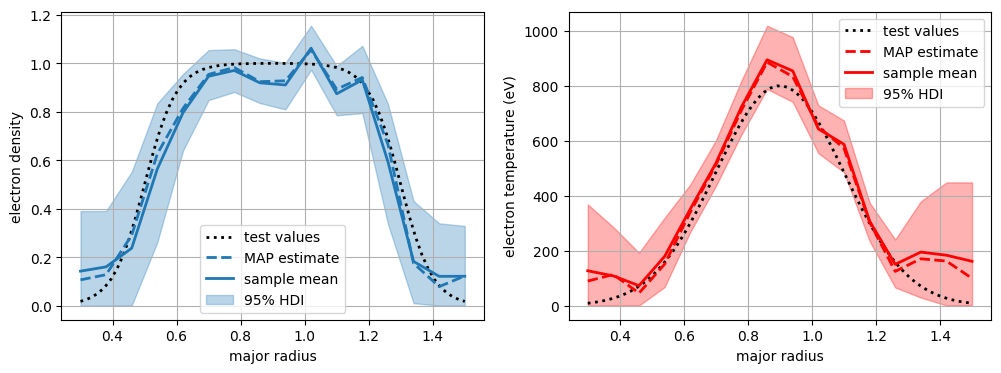

In [38]:
fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(test_axis, test_ne, label="test values", c="black", ls="dotted", lw=2)
ax1.plot(field_axis, params_dict["ne"], label="MAP estimate", c="C0", ls="dashed", lw=2)
ax1.plot(field_axis, samples_mean["ne"], label="sample mean", c="C0", lw=2)
ax1.fill_between(field_axis, *samples_hdi_95["ne"], alpha=0.3, color="C0", label="95% HDI")
ax1.set_ylabel("electron density")
ax1.set_xlabel("major radius")
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(test_axis, test_te, color="black", lw=2, ls="dotted", label="test values")
ax2.plot(field_axis, params_dict["te"], color="red", lw=2, ls="dashed", label="MAP estimate")
ax2.plot(field_axis, samples_mean["te"], color="red", lw=2, label="sample mean")
ax2.fill_between(field_axis, *samples_hdi_95["te"], color="red", alpha=0.3, label="95% HDI")
ax2.set_ylabel("electron temperature (eV)")
ax2.set_xlabel("major radius")
ax2.grid()
ax2.legend()

plt.show()